In [1225]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Hidden Markov Model Assignment

The robot can move on the cells with light background, but cannot go over the obstacles, which have the dark blue background.

In [1226]:
# Boolean representation of a random maze. True=feasible, False=obstacle.
# Use the maze corresponding to your group!
maze = np.array([
    [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1],
    [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
])

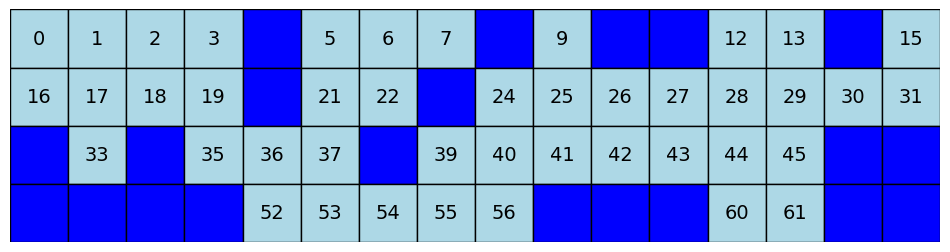

In [1227]:
def plot_maze(ax, maze, skip_walls=True, Z=None):
    cell_idx = 0
    rows, cols = maze.shape
    for r in range(rows):
        for c in range(cols):
            color = 'lightblue' if maze[r, c] == 1 else 'blue'

            if Z is not None and (r * cols + c) in Z:
                color = 'red'

            ax.add_patch(patches.Rectangle((c, rows - 1 - r), 1, 1, edgecolor='black', facecolor=color))
            if maze[r, c] == 1 or not skip_walls:
                ax.text(c + 0.5, rows - 1 - r + 0.5, str(cell_idx), color='black', ha='center', va='center',
                        fontsize=14)
            cell_idx += 1

    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)

    ax.set_aspect('equal')
    ax.axis('off')


fig, ax = plt.subplots(figsize=(12, 9))

plot_maze(ax, maze)

In [1228]:
# Suggested names for possible states
rows, cols = maze.shape
states = [(r, c) for r in range(rows) for c in range(cols) if maze[r, c]]

In [1229]:
# Suggested names for the possible observations. If can be seen as a binary digit from 0 to 15, where the least significant bit indicates West.
# This may be usefule to code the emission matrix
letters = ['N', 'S', 'E', 'W']
vocabulary = []
for i in range(2 ** len(letters)):  # observations can be indexed with numbers 0 to 15
    binary = format(i, '04b')  # 4-bit format interpreted as possibility to move N,S,E,W
    combination = ''.join([letters[j] for j in range(4) if binary[j] == '1'])
    combination = '(' + combination + ')'
    vocabulary.append(combination)

In [1230]:
vocabulary

['()',
 '(W)',
 '(E)',
 '(EW)',
 '(S)',
 '(SW)',
 '(SE)',
 '(SEW)',
 '(N)',
 '(NW)',
 '(NE)',
 '(NEW)',
 '(NS)',
 '(NSW)',
 '(NSE)',
 '(NSEW)']

## 1 HMM Definition and Trajectory Generation

### 1.1 Transition probability definition

Define the *transition probability matrix* $A$ corresponding to the robot maze. Consider that:

* The robot can only reach a neighboring cell.
* The robot can move North, South, East, West.
* Diagonal moves are not allowed.
* Passing over obstacles is not allowed.
* Feasible transitions are equally probable.

In [1231]:
def create_path_matrix(maze):
    rows, cols = maze.shape
    f_len = rows * cols

    A = np.zeros((f_len, f_len))
    B = np.zeros((f_len, 2 ** len(letters)))

    arr = maze.flatten()

    # N,S,E,W
    for i in range(f_len):
        code = 0
        if arr[i] == 0:
            continue
        if (i + 1) % cols and arr[i + 1] == 1:  # E
            A[i, i + 1] = 1
            code += 2
        if i % cols and arr[i - 1] == 1:  # W
            A[i, i - 1] = 1
            code += 1
        if i + cols < f_len and arr[i + cols] == 1:  # S
            A[i, i + cols] = 1
            code += 4
        if i - cols >= 0 and arr[i - cols] == 1:  # N
            A[i, i - cols] = 1
            code += 8
        B[i, code] = 1
        pths = A[i, :].sum()
        if pths != 0:
            A[i, :] = A[i, :] / pths
    return A, B

In [1232]:
A, B = create_path_matrix(maze)
print(A.shape)

(64, 64)


### 1.2 Emission probability definition

Define the *emission probability matrix* $B$.
* After each move, the robot senses whether the cells to the North, South, East, West are feasible.
* There are 16 possible observations (previously defined variable `vocabulary`).

In [1233]:
print(B.shape)
print(B)

(64, 16)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### 1.3 Trajectory Sampling

Sample and visualize a state and observation sequences $Z$ and $Y$ of
length $T = 20$ compatible with the previous hypotheses.

* Use the previously defined transition and emission matrices
* Consider the initial position equiprobable among the admissible states

In [1234]:
start_prob = maze.copy()
start_prob = start_prob / start_prob.sum()

In [1235]:
def pick_random_start(start_prob):
    array = start_prob.flatten()
    return np.random.choice(range(len(array)), p=array)

In [1236]:
t = 20
Z = np.zeros(t, dtype=int)
Y = np.zeros(t, dtype=int)

In [1237]:
Z[0] = pick_random_start(start_prob)

In [1238]:
def traverse_z(Z, A):
    for i in range(1, t):
        Z[i] = np.random.choice(range(A.shape[0]), p=A[Z[i - 1]])


def build_y(Z, Y, B):
    for i in range(t):
        Y[i] = np.argmax(B[Z[i]])


[24 40 41 40 39 55 39 55 54 55 56 40 39 55 54 55 56 55 56 55]
[ 6 15 11 15  6 11  6 11  3 11  9 15  6 11  3 11  9 11  9 11]
['(SE)', '(NSEW)', '(NEW)', '(NSEW)', '(SE)', '(NEW)', '(SE)', '(NEW)', '(EW)', '(NEW)', '(NW)', '(NSEW)', '(SE)', '(NEW)', '(EW)', '(NEW)', '(NW)', '(NEW)', '(NW)', '(NEW)']


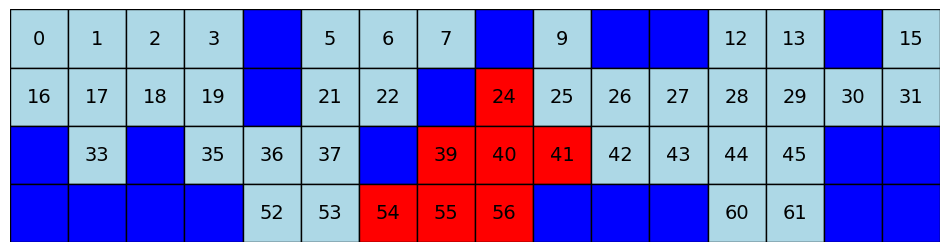

In [1239]:
traverse_z(Z, A)
print(Z)
build_y(Z, Y, B)
print(Y)
print(list(map(vocabulary.__getitem__, Y)))

fig, ax = plt.subplots(figsize=(12, 9))
plot_maze(ax, maze, Z=Z)

## 2 Decoding and inference

### 2.1 Likelihood
1
Compute the likelihood of the obtained observation sequence $Y$.

In [1240]:
def likelihood_calc(A, B, Y, pi):
    alpha = np.zeros((len(Y), len(B)))
    for i in range(len(B)):
        alpha[0][i] = pi[i // cols][i % cols] * B[i][Y[0]]
    for t in range(1, len(Y)):
        for j in range(len(B)):
            alpha[t][j] = B[j][Y[t]] * np.sum(alpha[t - 1] * A[:, j])
    return alpha, alpha[-1].sum()


alpha, likelihood = likelihood_calc(A, B, Y, start_prob)
likelihood

9.735406298848373e-10

### 2.1 Decoding 

Obtain the most probable state sequence, given the observation sequence $Y$.

In [1241]:
def viterbi(A, B, Y, pi):
    v = np.zeros((len(Y), len(B)))
    back = np.zeros((len(Y), len(B)), dtype=int)
    for i in range(len(B)):
        v[0][i] = pi[i // cols][i % cols] * B[i][Y[0]]
        back[0][i] = -1

    for t in range(1, len(Y)):
        for j in range(len(B)):
            scores = v[t - 1] * A[:, j]

            best_prev = np.argmax(scores)
            v[t][j] = B[j][Y[t]] * scores[best_prev]
            back[t][j] = best_prev

    path = np.zeros(len(Y), dtype=int)
    path[-1] = np.argmax(v[-1])

    for t in range(len(Y) - 2, -1, -1):
        path[t] = back[t + 1][path[t + 1]]

    return v, path


v, path = viterbi(A, B, Y, start_prob)

print(path)
print(Z)

[24 25 41 40 39 55 39 55 54 55 56 40 39 55 54 55 56 55 56 55]
[24 40 41 40 39 55 39 55 54 55 56 40 39 55 54 55 56 55 56 55]


### 2.2 Filtering

Obtain the filtering distribution $P(z_t \mid y_{1:t})$ at each time step $t$.

In [1242]:
def filtering(A, B, Y, pi):
    alpha, _ = likelihood_calc(A, B, Y, pi)
    return alpha / alpha.sum(axis=1, keepdims=True)


props_t = filtering(A, B, Y, start_prob)
props_t

array([[0.2, 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

### 2.3 Noisy observations

Repeat steps 2.1 and 2.2 in the presence of sensor error noise. In particular, consider that:
  * With probability $1-\epsilon$, the sensor provides the correct reading
  * With probability $\epsilon$, the sensor returns a wrong reading. 
  * The $\epsilon$ probability is equally split among all wrong readings.
  * Set $\epsilon=0.2$. Optionally, test also other values.

In [ ]:
esp = 0.2

#TODO tf?

## 3 Analysis and discussion

Comment the techniques applied and the obtained results.